In [1]:
#importing other required libraries
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import keras_tuner as kt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import Xception, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, Rescaling
from keras.utils.np_utils import to_categorical
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
import random
import cv2
import os
from pathlib import Path
from PIL import Image, ImageFile
from PIL import ImageFile
import splitfolders

In [2]:
SEED = 42

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
ImageFile.LOAD_TRUNCATED_IMAGES = True
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### MINC Dataset Preperation

In [5]:
# paramaters
batch_size= 32
epochs= 50
img_size = 150 
num_classes = 23

In [6]:
minc_train_dir = 'minc-2500/train'
minc_val_dir = 'minc-2500/val'
minc_test_dir = 'minc-2500/test'

# paramaters
batch_size= 32
epochs= 50
img_size = 150 

In [7]:
image_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range=0.2, 
    shear_range = 0.2,
    )

image_generator_test = ImageDataGenerator(preprocessing_function = preprocess_input)

In [8]:
# No augmentation of train set
train_ds = image_generator_test.flow_from_directory(
  minc_train_dir,
  shuffle = True,
  target_size = (img_size, img_size),
  class_mode = 'categorical',
  batch_size = batch_size
  )

val_ds = image_generator_test.flow_from_directory(
  minc_val_dir,
  shuffle = True,
  target_size = (img_size, img_size),
  class_mode = 'categorical',
  batch_size = batch_size
  )

test_ds = image_generator_test.flow_from_directory(
  minc_test_dir,
  shuffle = False,
  target_size = (img_size, img_size),
  class_mode = 'categorical',
  batch_size = batch_size
  )

Found 46000 images belonging to 23 classes.
Found 5750 images belonging to 23 classes.
Found 5750 images belonging to 23 classes.


### Xception base model (Transfer Learning)

In [10]:
base_model = Xception(
    weights = "imagenet",  # Load weights pre-trained on ImageNet.
    input_shape = (150, 150, 3),
    include_top = False,
)  # Do not include the ImageNet classifier at the top.

### Model without augmentation (Unfreeze)

In [20]:
# Freeze base model
base_model.trainable = True

#Adding layers to the Xception
minc_model=Sequential()
#Add the Dense layers along with activation and batch normalization
minc_model.add(base_model)
minc_model.add(Flatten())
minc_model.add(Dense(len(train_ds.class_indices),activation=('softmax')))

#Compiling Xception

minc_model.compile(optimizer = tf.keras.optimizers.SGD(0.001), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy'] )

In [21]:
history = minc_model.fit(train_ds, 
                    epochs=50, 
                    validation_data=val_ds)

Epoch 1/50
1438/1438 [==============================] - 182s 125ms/step - loss: 0.8709 - accuracy: 0.7406 - val_loss: 0.8145 - val_accuracy: 0.7544
Epoch 2/50
1438/1438 [==============================] - 164s 114ms/step - loss: 0.6866 - accuracy: 0.7847 - val_loss: 0.7909 - val_accuracy: 0.7602
Epoch 3/50
1438/1438 [==============================] - 164s 114ms/step - loss: 0.6461 - accuracy: 0.7961 - val_loss: 0.7899 - val_accuracy: 0.7597
Epoch 4/50
1438/1438 [==============================] - 162s 112ms/step - loss: 0.6252 - accuracy: 0.8027 - val_loss: 0.7859 - val_accuracy: 0.7612
Epoch 5/50
1438/1438 [==============================] - 162s 113ms/step - loss: 0.6089 - accuracy: 0.8060 - val_loss: 0.7881 - val_accuracy: 0.7631
Epoch 6/50
1438/1438 [==============================] - 161s 112ms/step - loss: 0.5896 - accuracy: 0.8125 - val_loss: 0.7914 - val_accuracy: 0.7607
Epoch 7/50
1438/1438 [==============================] - 162s 112ms/step - loss: 0.5831 - accuracy: 0.8133 - val_

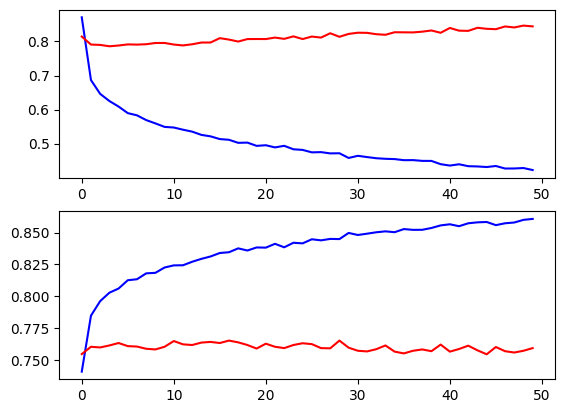

In [22]:
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column
#Training loss and validation loss
ax[0].plot(history.history['loss'],color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')
#Training accuracy and validation accuracy
ax[1].plot(history.history['accuracy'],color='b',label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [23]:
res = minc_model.evaluate(test_ds)

180/180 [==============================] - 8s 43ms/step - loss: 0.8256 - accuracy: 0.7548


### Best model (Unfreeze with augmentation and hyperparameter tuned)

In [9]:
# Augmentation
train_aug_ds = image_generator_test.flow_from_directory(
  minc_train_dir,
  shuffle = True,
  target_size = (img_size, img_size),
  class_mode = 'categorical',
  batch_size = batch_size
  )

Found 46000 images belonging to 23 classes.


In [10]:
best_dropout = 0.1
best_units = 1024
best_learning_rate = 0.0006000000000000001

In [11]:
# unfreeze the base_model
base_model.trainable = True

minc_model_Xception=Sequential()
#Add the Dense layers along with activation and batch normalization
minc_model_Xception.add(base_model)
minc_model_Xception.add(Flatten())
#Add the Dense layers along with activation and batch normalization
minc_model_Xception.add(Dense(best_units,activation='relu')) 
minc_model_Xception.add(Dropout(best_dropout))
minc_model_Xception.add(Dense(best_units,activation='relu'))
minc_model_Xception.add(Dropout(best_dropout))
minc_model_Xception.add(Dense(best_units,activation='relu'))
minc_model_Xception.add(Dropout(best_dropout))
minc_model_Xception.add(Dense(len(train_ds.class_indices),activation=('softmax')))

minc_model_Xception.compile(optimizer = tf.keras.optimizers.SGD(best_learning_rate), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy'])

In [12]:
history = minc_model_Xception.fit(train_aug_ds, 
                    epochs=50, 
                    validation_data=val_ds)

Epoch 1/50
1438/1438 [==============================] - 190s 128ms/step - loss: 2.9057 - accuracy: 0.1682 - val_loss: 2.3804 - val_accuracy: 0.3706
Epoch 2/50
1438/1438 [==============================] - 168s 116ms/step - loss: 2.2282 - accuracy: 0.3698 - val_loss: 1.6841 - val_accuracy: 0.5177
Epoch 3/50
1438/1438 [==============================] - 165s 115ms/step - loss: 1.7710 - accuracy: 0.4745 - val_loss: 1.4521 - val_accuracy: 0.5701
Epoch 4/50
1438/1438 [==============================] - 166s 115ms/step - loss: 1.5835 - accuracy: 0.5216 - val_loss: 1.3370 - val_accuracy: 0.6017
Epoch 5/50
1438/1438 [==============================] - 167s 116ms/step - loss: 1.4671 - accuracy: 0.5573 - val_loss: 1.2651 - val_accuracy: 0.6238
Epoch 6/50
1438/1438 [==============================] - 166s 115ms/step - loss: 1.3792 - accuracy: 0.5817 - val_loss: 1.2005 - val_accuracy: 0.6381
Epoch 7/50
1438/1438 [==============================] - 166s 115ms/step - loss: 1.3108 - accuracy: 0.5997 - val_

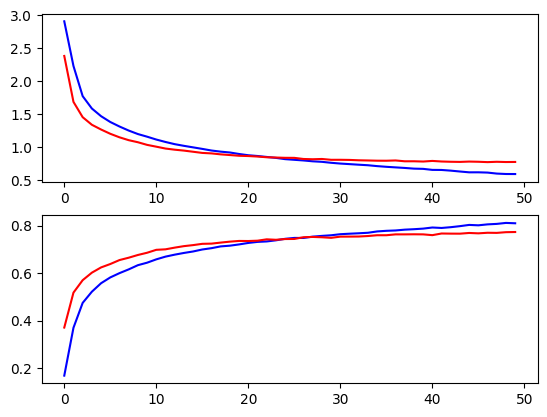

In [13]:
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column
#Training loss and validation loss
ax[0].plot(history.history['loss'],color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')
#Training accuracy and validation accuracy
ax[1].plot(history.history['accuracy'],color='b',label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [15]:
res = minc_model_Xception.evaluate(test_ds)

180/180 [==============================] - 8s 43ms/step - loss: 0.7646 - accuracy: 0.7668


In [16]:
pred = minc_model_Xception.predict(test_ds, steps=len(test_ds), verbose=1)

180/180 [==============================] - 16s 86ms/step


In [17]:
predicted_class_indices = np.argmax(pred, axis=1)

In [18]:
labels = (test_ds.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [27]:
filenames = test_ds.filenames
results = pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results['Correct_Prediction'] = results.apply(lambda x: x.Predictions in x.Filename, axis=1)

In [26]:
results

,Filename,Predictions,Correct Prediction
0,brick\brick_000001.jpg,brick,True
1,brick\brick_000006.jpg,brick,True
2,brick\brick_000024.jpg,brick,True
3,brick\brick_000027.jpg,hair,False
4,brick\brick_000035.jpg,stone,False
...,...,...,...
5745,wood\wood_002456.jpg,wood,True
5746,wood\wood_002465.jpg,wood,True
5747,wood\wood_002472.jpg,polishedstone,False
5748,wood\wood_002475.jpg,wood,True
